# Perfil de comércio

## Setup

In [1]:
import comtradetools as comtradetools

comtradetools.setup()

### Inicializar a API

In [2]:
import comtradetools as comtradetools

APIKEY = comtradetools.get_api_key()

comtradetools.init(APIKEY, force_init=True)
comtradetools.CALLS_PER_PERIOD=10  # Period default is 60 seconds


un-comtrade codebook downloaded to support/codebook.xlsx
un-comtrade country groups downloaded to support/Dim_Countries_Hierarchy_UnctadStat_All_Flat.csv


## Country and period of interest

Choose country and years of interest

In [3]:
import comtradetools

country_of_interest = comtradetools.m49_angola
country_of_interest_desc = comtradetools.COUNTRY_CODES[country_of_interest]

years_of_interest=comtradetools.year_range(2010,2021)
print(country_of_interest_desc, years_of_interest)

Angola 2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021


## Trade balance

In [4]:
import comtradetools
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

periods = comtradetools.split_period(years_of_interest,12)
global_trade = pd.DataFrame()
for period in periods:
    print(f"Fetching data for period {period}")

    temp = comtradetools.get_trade_flows(country_of_interest, 
                                                   period=period,
                                                   symmetric_values=True)
                         
    global_trade = pd.concat([global_trade,temp])


global_trade = global_trade.replace(0, np.nan)



Fetching data for period 2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021


In [5]:
import numpy as np



global_trade

flowCode,M,M<X,X,X<M,trade_balance (X-M),trade_balance (X<M-M),trade_volume (X+M),trade_volume (X<M+M)
period,,,,,,,,
2010,"18,143,268,908.00","15,871,622,642.40","52,612,114,761.00","53,459,185,324.68","34,468,845,853.00","35,315,916,416.68","70,755,383,669.00","71,602,454,232.68"
2011,"20,790,996,039.00","18,521,452,431.48","66,427,390,220.00","66,204,920,204.59","45,636,394,181.00","45,413,924,165.59","87,218,386,259.00","86,995,916,243.59"
2012,"28,722,984,064.00","21,470,797,538.92","70,863,076,413.00","75,490,334,173.90","42,140,092,349.00","46,767,350,109.90","99,586,060,477.00","104,213,318,237.90"
2013,"26,756,062,991.00","23,728,551,716.02","67,712,526,547.00","72,305,260,157.15","40,956,463,556.00","45,549,197,166.15","94,468,589,538.00","99,061,323,148.15"
2014,"28,753,499,329.00","28,333,262,583.05","58,672,369,190.00","64,694,135,949.55","29,918,869,861.00","35,940,636,620.55","87,425,868,519.00","93,447,635,278.55"
2015,"21,549,256,530.51","18,429,407,926.75","33,924,937,478.31","36,829,899,264.38","12,375,680,947.80","15,280,642,733.87","55,474,194,008.82","58,379,155,794.89"
2016,"14,347,710,497.80","11,567,121,254.47","28,057,499,522.39","28,304,363,119.09","13,709,789,024.59","13,956,652,621.29","42,405,210,020.19","42,652,073,616.89"
2017,"15,462,313,478.23","11,855,347,823.95","34,904,881,109.37","36,704,443,851.05","19,442,567,631.14","21,242,130,372.82","50,367,194,587.60","52,166,757,329.28"
2018,"16,006,910,579.06","10,328,693,528.99","40,664,718,814.96","44,183,954,089.23","24,657,808,235.90","28,177,043,510.17","56,671,629,394.02","60,190,864,668.29"


In [6]:
start_year=global_trade.index.min()
end_year=global_trade.index.max()
excel_file = f"reports/{country_of_interest_desc}_trade_profile_{start_year}-{end_year}.xlsx"
global_trade.to_excel(excel_file)

0 Line2D(M) red
1 Line2D(M<X) lightsalmon
2 Line2D(X) green
3 Line2D(X<M) lightgreen
4 Line2D(trade_balance (X-M)) darkviolet
5 Line2D(trade_balance (X<M-M)) violet
6 Line2D(trade_volume (X+M)) blue
7 Line2D(trade_volume (X<M+M)) dodgerblue


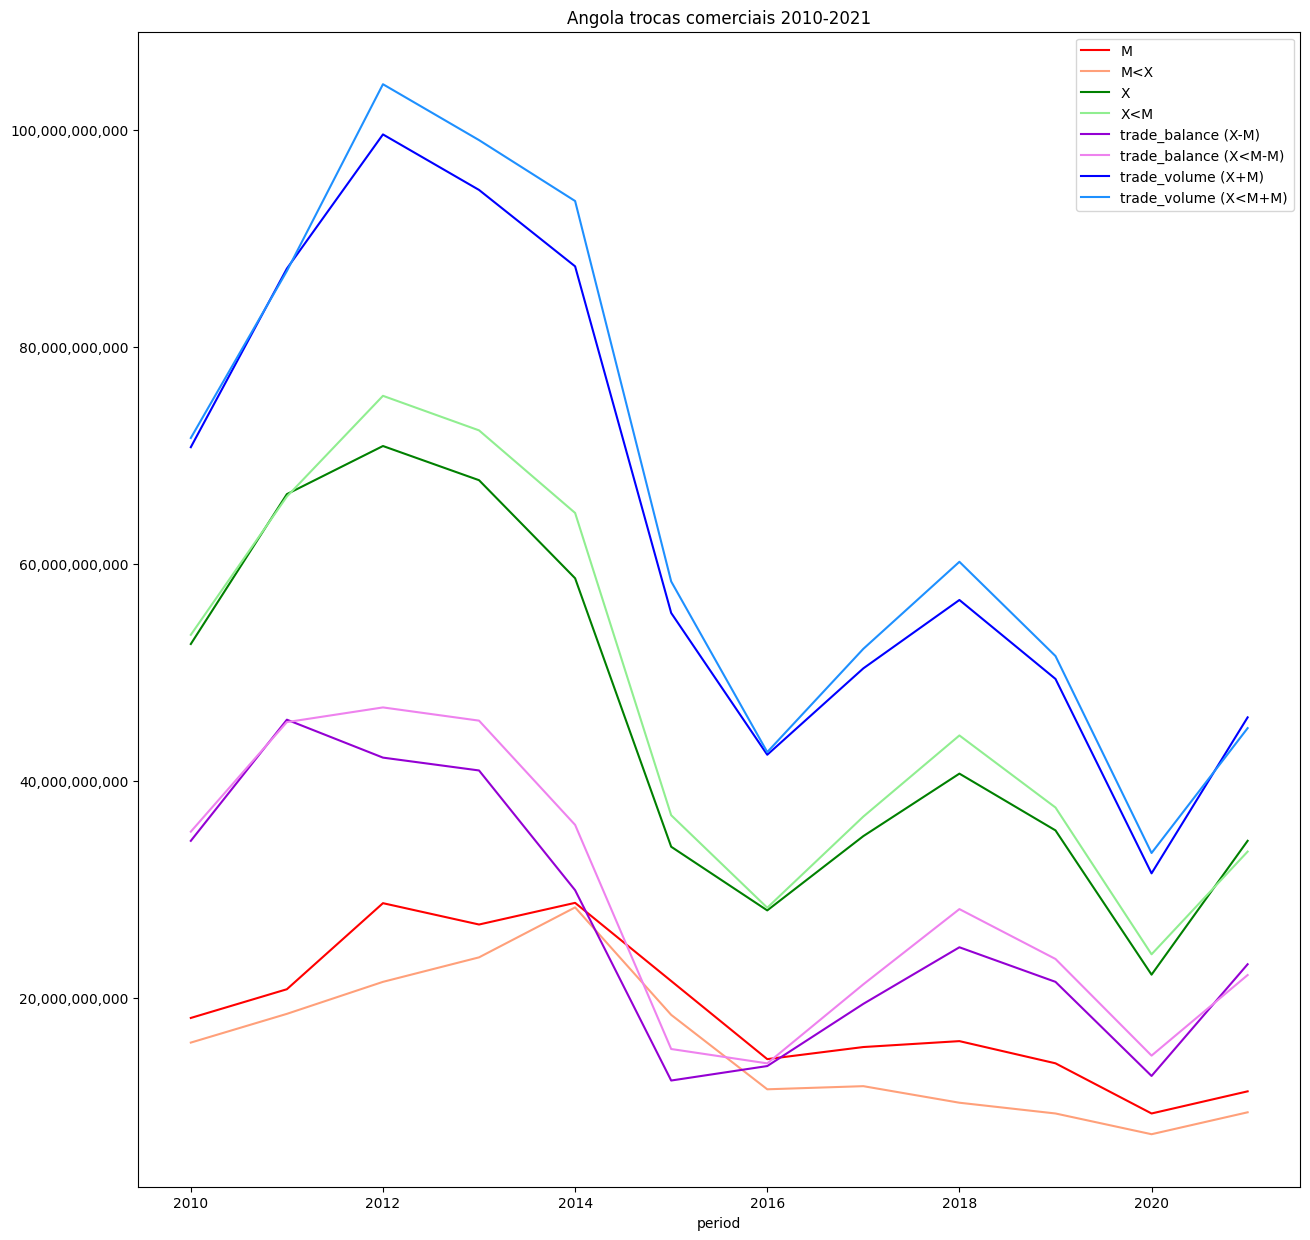

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

start_year=global_trade.index.min()
end_year=global_trade.index.max()
title=f"{country_of_interest_desc} trocas comerciais {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_desc}_trade_profile_{start_year}-{end_year}.png"
fig = global_trade.plot.line(figsize=(15,15),title=title)
# see https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue']
for i, line in enumerate(fig.get_lines()):
    print(i, line, colors[i])
    line.set_color(colors[i])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig.yaxis.set_major_formatter(formatter)
fig.legend(list(global_trade.columns.astype(str)))

plt.savefig(plotfile)
plt.show()

## Exports

Usamos as importações declaradas pelos parceiros para obter as
exportações do país de interesse.

### Main export partners of the country

In [10]:

# We get the exports from the reported imports of all the countries
# i.e. instead of asking Angola for export data we ask the world for import data from Angola

# years_of_interest = comtrade.year_range(2020, 2021)  
df = comtradetools.getFinalData(APIKEY,
                                reporterCode=None,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='M',
                                period=years_of_interest,
                                partnerCode=country_of_interest,
                                partner2Code=0,  # world
                                clCode="HS",
                                cmdCode="TOTAL",
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True                      
                                )

In [12]:
df.head()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20100101,2010,52,2010,12,DZA,Algeria,M,...,NaN,False,NaN,False,"3,845,443.00",NaN,"3,845,443.00",0,True,False
1,C,A,20100101,2010,52,2010,31,AZE,Azerbaijan,M,...,NaN,False,NaN,False,"5,766.00",NaN,"5,766.00",0,True,False
2,C,A,20100101,2010,52,2010,32,ARG,Argentina,M,...,NaN,False,NaN,False,"4,081.00",NaN,"4,081.00",0,True,False
3,C,A,20100101,2010,52,2010,36,AUS,Australia,M,...,NaN,False,NaN,False,"93,811.00",NaN,"93,811.00",0,True,False
4,C,A,20100101,2010,52,2010,40,AUT,Austria,M,...,NaN,False,NaN,False,"51,545.00",NaN,"51,545.00",0,True,False


Utility function for formatting columns in the trade profile dataframes
"""

In [13]:
def make_format(cols:list):
    f = {col:'{0:.3%}' for col in cols if col.endswith('_perc')}
    f.update({col:'${0:,.0f}' for col in cols if col.endswith('_sum')})
    f.update({'primaryValue':'${0:,.0f}'})
    return f


In [14]:
import pandas as pd
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5 

# aggregate by year, flow, reporter 
exports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode','reporterDesc'],
                                   col='primaryValue',
                                   prefix='partner',
                                   drop_duplicates=True)

cols=['refYear','flowCode','reporterDesc','cmdCode','partner_upper_sum','partner_sum','partner_rank','partner_perc','partner_upper_perc']

formats =  make_format(cols)

top_export_partners = exports[exports['partner_rank']<=show_only_top]['reporterDesc'].unique()
top_export_partners_codes = exports[exports['partner_rank']<=show_only_top]['reporterCode'].unique()

print(f"Top {show_only_top} export partners of {country_of_interest_desc} in {years_of_interest}: \n{top_export_partners}")
exports[exports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank','reporterDesc','cmdCode']).style.format(formats)

Top 5 export partners of Angola in 2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021: 
['China' 'France' 'Other Asia, nes' 'India' 'USA' 'Canada' 'South Africa'
 'Portugal' 'Spain' 'United Arab Emirates' 'Thailand']


,refYear,flowCode,reporterDesc,cmdCode,partner_upper_sum,partner_sum,partner_rank,partner_perc,partner_upper_perc
17,2010,M,China,TOTAL,"$53,459,185,325","$22,815,049,454",1,42.678%,42.678%
96,2010,M,USA,TOTAL,"$53,459,185,325","$12,273,944,969",2,22.959%,22.959%
77,2010,M,India,TOTAL,"$53,459,185,325","$4,838,456,716",3,9.051%,9.051%
56,2010,M,"Other Asia, nes",TOTAL,"$53,459,185,325","$2,859,560,967",4,5.349%,5.349%
31,2010,M,France,TOTAL,"$53,459,185,325","$2,126,302,876",5,3.977%,3.977%
117,2011,M,China,TOTAL,"$66,204,920,205","$24,922,180,492",1,37.644%,37.644%
201,2011,M,USA,TOTAL,"$66,204,920,205","$13,833,012,040",2,20.894%,20.894%
178,2011,M,India,TOTAL,"$66,204,920,205","$6,005,484,849",3,9.071%,9.071%
157,2011,M,"Other Asia, nes",TOTAL,"$66,204,920,205","$5,665,315,729",4,8.557%,8.557%
114,2011,M,Canada,TOTAL,"$66,204,920,205","$2,469,608,910",5,3.730%,3.730%


Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [15]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns='reporterDesc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna('',inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0)

partner_perc                                               \
reporterDesc          Albania Algeria Angola Antigua and Barbuda Argentina   
refYear flowDesc                                                             
2010    Import           0.00    0.00   0.00                0.00      0.00   
2011    Import           0.00    0.00   0.00                0.00      0.00   
2012    Import           0.00    0.00   0.00                0.00      0.00   
2013    Import           0.00    0.00   0.00                0.00      0.00   
2014    Import           0.00    0.00   0.00                0.00      0.00   
2015    Import           0.00    0.00   0.00                0.00      0.00   
2016    Import           0.00    0.00   0.00                0.00      0.00   
2017    Import           0.00    0.00   0.00                0.00      0.00   
2018    Import           0.00    0.00   0.00                0.00      0.00   
2019    Import           0.00    0.00   0.00                0.00      0.00   
2020    Import           0.00    0.00   0.00                0.00      0.00   
2021    Import           0.00    0.00   0.00                0.00      0.00   

                                                               ...  \
reporterDesc     Armenia Australia Austria Azerbaijan Bahamas  ...   
refYear flowDesc                                               ...   
2010    Import      0.00      0.00    0.00       0.00    0.00  ...   
2011    Import      0.00      0.00    0.00       0.00    0.00  ...   
2012    Import      0.00      0.00    0.00       0.00    0.00  ...   
2013    Import      0.00      0.00    0.00       0.00    0.00  ...   
2014    Import      0.00      0.00    0.00       0.00    0.00  ...   
2015    Import      0.00      0.00    0.00       0.00    0.00  ...   
2016    Import      0.00      0.00    0.00       0.00    0.00  ...   
2017    Import      0.00      0.00    0.00       0.00    0.00  ...   
2018    Import      0.00      0.00    0.00       0.00    0.00  ...   
2019    Import      0.00      0.00    0.00       0.00    0.00  ...   
2020    Import      0.00      0.00    0.00       0.00    0.00  ...   
2021    Import      0.00      0.00    0.00       0.00    0.00  ...   

                 primaryValue                                        \
reporterDesc          Ukraine United Arab Emirates   United Kingdom   
refYear flowDesc                                                      
2010    Import     266,853.00       189,747,877.00    66,700,476.00   
2011    Import     146,120.00       301,582,058.00   437,170,828.00   
2012    Import     764,720.00     1,234,968,772.00 1,261,394,647.00   
2013    Import      63,422.00       757,063,814.73   994,286,997.00   
2014    Import      11,069.00       812,542,196.16   650,319,421.00   
2015    Import      50,320.00     1,056,613,911.80 1,006,251,202.00   
2016    Import     299,907.11       956,305,699.01   369,342,914.00   
2017    Import      72,378.45     1,200,168,189.47    71,778,081.35   
2018    Import      20,096.32     1,569,493,453.56    83,063,568.65   
2019    Import     251,112.36     1,294,307,774.80    17,811,494.08   
2020    Import      35,298.67     1,018,255,600.93     1,979,755.60   
2021    Import       1,389.42     1,685,701,656.52     7,990,634.18   

                                                                      \
reporterDesc     United Rep. of Tanzania        Uruguay    Venezuela   
refYear flowDesc                                                       
2010    Import              3,317,051.00           0.00   121,334.00   
2011    Import                446,021.00          16.00 1,852,323.00   
2012    Import              1,026,793.00           0.00 1,947,136.00   
2013    Import                268,888.00 315,549,401.00   242,598.00   
2014    Import              3,407,296.00 217,485,863.00         0.00   
2015    Import                 16,852.00       1,019.00         0.00   
2016    Import                 26,245.00 226,117,355.00         0.00   
2017    I

In [16]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]
pivoted[show_only_columns]

partner_perc                                              \
reporterDesc           Canada China France India Other Asia, nes Portugal   
refYear flowDesc                                                            
2010    Import           0.03  0.43   0.04  0.09            0.05     0.01   
2011    Import           0.04  0.38   0.03  0.09            0.09     0.02   
2012    Import           0.03  0.44   0.02  0.11            0.07     0.03   
2013    Import           0.02  0.44   0.02  0.09            0.05     0.05   
2014    Import           0.02  0.48   0.03  0.09            0.05     0.03   
2015    Import           0.01  0.43   0.04  0.09            0.04     0.03   
2016    Import           0.00  0.49   0.04  0.07            0.05     0.03   
2017    Import           0.00  0.56   0.01  0.11            0.04     0.01   
2018    Import           0.00  0.58   0.01  0.10            0.01     0.03   
2019    Import           0.00  0.63   0.01  0.10            0.01     0.03   
2020    Import           0.00  0.61   0.02  0.08            0.02     0.02   
2021    Import           0.00  0.62   0.01  0.07            0.01     0.00   

                                                   ...      primaryValue  \
reporterDesc     South Africa Spain Thailand  USA  ...             China   
refYear flowDesc                                   ...                     
2010    Import           0.04  0.01     0.00 0.23  ... 22,815,049,454.00   
2011    Import           0.02  0.01     0.00 0.21  ... 24,922,180,492.00   
2012    Import           0.04  0.02     0.00 0.13  ... 33,561,896,917.00   
2013    Import           0.03  0.04     0.00 0.12  ... 31,972,669,347.00   
2014    Import           0.03  0.06     0.00 0.09  ... 31,106,015,046.00   
2015    Import           0.04  0.06     0.00 0.08  ... 16,001,611,383.00   
2016    Import           0.05  0.03     0.01 0.11  ... 13,966,117,080.00   
2017    Import           0.04  0.03     0.01 0.07  ... 20,698,709,467.00   
2018    Import           0.03  0.03     0.02 0.06  ... 25,826,510,355.00   
2019    Import           0.02  0.03     0.02 0.03  ... 23,837,402,142.00   
2020    Import           0.00  0.03     0.05 0.02  ... 14,757,730,338.00   
2021    Import           0.01  0.02     0.05 0.03  ... 20,908,231,317.00   

                                                                     \
reporterDesc               France            India  Other Asia, nes   
refYear flowDesc                                                      
2010    Import   2,126,302,876.00 4,838,456,716.00 2,859,560,967.00   
2011    Import   1,825,704,019.00 6,005,484,849.00 5,665,315,729.00   
2012    Import   1,199,927,582.00 8,020,442,181.00 5,004,958,562.00   
2013    Import   1,225,880,863.00 6,798,300,153.00 3,855,306,649.00   
2014    Import   2,079,376,220.00 5,641,667,702.00 2,955,558,824.00   
2015    Import   1,610,479,858.00 3,169,598,580.00 1,363,633,941.00   
2016    Import   1,029,963,745.00 2,001,936,255.00 1,312,764,415.00   
2017    Import     370,588,475.79 4,118,279,131.90 1,479,442,599.65   
2018    Import     600,213,206.89 4,337,925,217.50   370,988,214.94   
2019    Import     509,673,910.45 3,799,563,165.19   193,528,064.67   
2020    Import     498,016,078.52 2,022,432,688.74   498,675,434.50   
2021    Import     232,767,839.46 2,315,947,568.41   286,366,020.88   

                                                                     \
reporterDesc             Portugal     South Africa            Spain   
refYear flowDesc                                                      
2010    Import     746,364,900.00 2,001,779,408.82   621,951,979.45   
2011    Import   1,639,710,523.00 1,586,176,196.93   587,380,397.71   
2012    Import   2,290,610,271.00 2,802,783,009.10 1,424,748,647.92   
2013    Import   3,495,088,409.00 1,958,574,119.85 2,883,313,128.47   
2014    Import   2,132,511,992.00 2,011,018,978.76 3,616,693,014.01   
2015    Import   1,266,536,955.09 1,344,214,553.60 2,241,044,685.06   
2016    Import 

#### Export to Excel

In [17]:
exports.to_excel(f'reports/{country_of_interest_desc}_top_partners.xlsx')
pivoted.to_excel(f'reports/{country_of_interest_desc}_top_partners_cols.xlsx')
pivoted[show_only_columns].to_excel(f'reports/{country_of_interest_desc}_export_top_{show_only_top}_partners_cols.xlsx')

## Exports: products

### Main exported products

In [10]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)  


Get the products imported from Angola

In [11]:
df = comtradetools.get_data(reporterCode=None,
                       typeCode='C',  # commodities
                       freqCode='A',  # annual
                       partnerCode=country_of_interest,
                       period=years_of_interest,
                       cmdCode='AG4',  # Top level product types
                       motCode=0,  # all means of transport
                       flowCode='M',
                       timeout=120)

In [12]:
import pandas as pd
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5 
exports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
exports = exports[exports['product_rank']<=show_only_top]

cols=['refYear','flowCode','cmdCode','product_sum','product_rank','product_perc','product_upper_sum','product_upper_perc']
formats =  make_format(cols)

top_export_products_codes = exports['cmdCode'].unique()

print(f"Top products exported by {country_of_interest_desc} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
exports[cols].sort_values(['refYear','flowCode','product_rank']).style.format(formats)


Top products exported by Angola in 2007,2008,2009,2010,2014,2015,2016,2017,2018,2019,2020,2021:
 ['2709' '2710' '7102' '9999' '8905' '2711' '8901' '7204' '8419' '0303'
 '2516' '2715']
   2709: Petroleum oils and oils obtained from bituminous minerals; crude
   2710: Petroleum oils and oils from bituminous minerals, not crude; preparations n.e.c, containing by weight 70% or more of petroleum oils or oils from bituminous minerals; these being the basic constituents of the preparations; waste oils
   7102: Diamonds, whether or not worked, but not mounted or set
   9999: Commodities not specified according to kind
   8905: Light-vessels, fire-floats, dredgers, floating cranes, other vessels; the navigability of which is subsidiary to main function; floating docks, floating, submersible drilling, production platforms
   2711: Petroleum gases and other gaseous hydrocarbons
   8901: Cruise ships, excursion boats, ferry-boats, cargo ships, barges and similar vessels for the transport of person

,refYear,flowCode,cmdCode,product_sum,product_rank,product_perc,product_upper_sum,product_upper_perc
7,2007,M,2709,"$38,353,255,496",1,2.043%,"$41,704,795,548",91.964%
147,2007,M,9999,"$756,136,900",2,0.000%,"$41,704,795,548",1.813%
317,2007,M,8905,"$685,462,362",3,1.644%,"$41,704,795,548",1.644%
54,2007,M,7102,"$629,792,010",4,0.598%,"$41,704,795,548",1.510%
9,2007,M,2710,"$424,218,083",5,0.041%,"$41,704,795,548",1.017%
2118,2008,M,2709,"$65,415,688,359",1,3.246%,"$67,748,939,616",96.556%
2180,2008,M,7102,"$891,139,665",2,0.238%,"$67,748,939,616",1.315%
2120,2008,M,2710,"$503,734,811",3,0.046%,"$67,748,939,616",0.744%
2121,2008,M,2711,"$377,344,746",4,0.094%,"$67,748,939,616",0.557%
2459,2008,M,8901,"$246,575,238",5,0.355%,"$67,748,939,616",0.364%


#### Export to Excel

In [13]:
exports.to_excel(f'{country_of_interest_desc}_exports_products_{exports["refYear"].min()}-{exports["refYear"].max()}.xlsx')

## Export partners / products analysis

What are the partners buying the top exports of country of interest?


In [14]:
import pandas as pd
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5 
print(f"Top products exported by {country_of_interest_desc} in {years_of_interest}:\n {top_export_products_codes}")
for cmdCode in top_export_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='cmd_partner'
products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode','reporterCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear','flowCode','cmdDesc','cmdCode','reporterDesc',f'{prefix}_sum',f'{prefix}_rank',f'{prefix}_upper_sum',f'{prefix}_perc']
formats=make_format(cols)
products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_export_products_codes) 
                       & (products_and_partners[f'{prefix}_rank']<=show_only_top))]


Top products exported by Angola in 2007,2008,2009,2010,2014,2015,2016,2017,2018,2019,2020,2021:
 ['2709' '2710' '7102' '9999' '8905' '2711' '8901' '7204' '8419' '0303'
 '2516' '2715']
   2709: Petroleum oils and oils obtained from bituminous minerals; crude
   2710: Petroleum oils and oils from bituminous minerals, not crude; preparations n.e.c, containing by weight 70% or more of petroleum oils or oils from bituminous minerals; these being the basic constituents of the preparations; waste oils
   7102: Diamonds, whether or not worked, but not mounted or set
   9999: Commodities not specified according to kind
   8905: Light-vessels, fire-floats, dredgers, floating cranes, other vessels; the navigability of which is subsidiary to main function; floating docks, floating, submersible drilling, production platforms
   2711: Petroleum gases and other gaseous hydrocarbons
   8901: Cruise ships, excursion boats, ferry-boats, cargo ships, barges and similar vessels for the transport of person

### Partners for main export products

In [ ]:

products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                         ascending=[True,True,False,True]).style.format(formats) #.hide(axis='index')

### Main partners and products

In [ ]:
print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='partner_cmd'
partners_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode','reporterCode','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['reporterDesc','refYear','flowCode','cmdDesc','cmdCode',f'{prefix}_sum',f'{prefix}_rank',f'{prefix}_upper_sum',f'{prefix}_perc']
formats=make_format(cols)
partners_and_products=partners_and_products[(partners_and_products['cmdCode'].isin(top_export_products_codes) 
                       & (partners_and_products[f'{prefix}_rank']<=show_only_top))]


partners_and_products[partners_and_products[f'{prefix}_rank']==1][cols].sort_values(['reporterDesc','refYear','flowCode',f'{prefix}_sum'],
                                         ascending=[True,True,True,False]).style.format(formats).hide(axis='index')

In [21]:

partners_and_products['reporterDesc'].unique()

array(['Algeria', 'Brazil', 'Belgium', 'Cambodia', 'China', 'Croatia',
       'Canada', 'Chile', 'Congo', 'Denmark', 'France and Monaco',
       'Ecuador', 'Germany', 'China Hong Kong', 'Japan', 'Italy',
       'Republic of Korea', 'Mexico', 'Indonesia', 'Israel',
       "Côte d'Ivoire", 'Malaysia', 'Montenegro',
       'Asia, not elsewhere specified', 'Poland', 'Peru', 'Portugal',
       'Sao Tome and Principe', 'Morocco', 'Russian Federation',
       'Netherlands', 'Serbia', 'Slovenia', 'India', 'Singapore',
       'South Africa', 'Zimbabwe', 'Spain', 'Switzerland', 'Thailand',
       'United Arab Emirates', 'Former Sudan', 'Turkey', 'United Kingdom',
       'United States of America', 'Belize', 'Cameroon', 'Azerbaijan',
       'Botswana', 'Benin', 'Colombia', 'El Salvador', 'Guatemala',
       'Mauritius', 'Kazakhstan', 'Lebanon', 'Norway', 'Nicaragua',
       'Niger', 'Pakistan', 'Nigeria', 'Anguilla', 'Slovakia', 'Vietnam',
       'Sweden', 'Uruguay', 'Burkina Faso', 'Austria', 'B



Por cada combinação ano, país parceiro, produto importado, obtém as importações
desse produto pelo parceiro e calcula o ranking do país em análise nas importações
desse produto pelo parceiro.

In [22]:
combos_of_interest = partners_and_products[(partners_and_products['cmdCode'].isin(top_export_products_codes) 
                       & (partners_and_products['reporterCode'].isin(top_export_partners_codes)))][['reporterCode','cmdCode']].drop_duplicates()
combos_of_interest
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
combos_of_interest

[(156, '2516'),
 (124, '2709'),
 (156, '2709'),
 (156, '7102'),
 (251, '2709'),
 (251, '2711'),
 (490, '2516'),
 (490, '2709'),
 (620, '2709'),
 (620, '7204'),
 (699, '2709'),
 (710, '2709'),
 (710, '2710'),
 (699, '7204'),
 (724, '0303'),
 (724, '2516'),
 (724, '2709'),
 (764, '2709'),
 (764, '7102'),
 (784, '7102'),
 (764, '7204'),
 (784, '7204'),
 (842, '2709'),
 (842, '2710'),
 (842, '2711'),
 (842, '7102'),
 (124, '2516'),
 (490, '7204'),
 (710, '7102'),
 (724, '2711'),
 (842, '9999'),
 (156, '2711'),
 (124, '7102'),
 (620, '2710'),
 (490, '2711'),
 (699, '2516'),
 (724, '7204'),
 (251, '9999'),
 (699, '7102'),
 (764, '2711'),
 (620, '2711'),
 (490, '9999'),
 (699, '2711'),
 (124, '9999'),
 (710, '2711'),
 (620, '2516'),
 (124, '2711'),
 (251, '2710'),
 (156, '2715')]

## Get the alternative suppliers for country_of_interest partners



In [23]:
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

In [42]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)


df = comtradetools.get_data(reporterCode=countryCodeCSV,
                       typeCode='C',  # commodities
                       freqCode='A',  # annual
                       partnerCode=None,
                       period=years_of_interest,
                       cmdCode=cmdCodeCSV,  # Top level product types
                       motCode=0,  # all means of transport
                       flowCode='M',
                       timeout=500)

Years of interest:  2007,2008,2009,2010,2014,2015,2016,2017,2018,2019,2020,2021
countryCodeCSV:  764,710,490,842,620,784,156,724,251,124,699
cmdCodeCSV:  2710,7204,2709,2516,7102,2711,9999,2715,0303


/Users/jrc/develop/cipf-comtrade/comtrade.py:344: UserWarning: Server returned HTTP Status: 500
  if days_since_modification <= 1:


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Alternative, concatenating

In [28]:
import pandas as pd

df2: pd.DataFrame = None
for countryCode,cmdCode in combos_of_interest:
    print(countryCode,cmdCode)
    tmp = comtradetools.get_data(reporterCode=countryCode,
                       typeCode='C',  # commodities
                       freqCode='A',  # annual
                       partnerCode=None,
                       period=years_of_interest,
                       cmdCode=cmdCode,  # Top level product types
                       motCode=0,  # all means of transport
                       flowCode='M',
                       timeout=500)
    if df2 is None:
        df2 = tmp
    else:
        df2 = pd.concat([df2,tmp],axis=0)
df=df2

156 2516
124 2709
156 2709
156 7102
251 2709
251 2711
490 2516
490 2709
620 2709
620 7204
699 2709
710 2709
710 2710


699 7204
724 0303
724 2516


/workspaces/cipf-comtrade/comtrade.py:358: UserWarning: Server returned HTTP Status: 500
  if resp.status_code != 200:


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [27]:
df.reporterDesc.unique()

array(['Algeria', 'Bosnia and Herzegovina', 'Belgium', 'Botswana',
       'Argentina', 'Brazil', 'Austria', 'Azerbaijan', 'Bulgaria',
       'Cameroon', 'Australia', 'Bangladesh', 'Cambodia', 'Croatia',
       'Chile', 'Denmark', 'China', 'Canada', 'Congo', 'Costa Rica',
       'Czechia', 'Cape Verde', 'Dominican Republic', 'Benin', 'Mayotte',
       'Colombia', 'France and Monaco', 'Gabon', 'Ecuador', 'Finland',
       'State of Palestine', 'Estonia', 'Gambia', 'China Hong Kong',
       'Germany', 'Honduras', 'Ghana', 'Guatemala', 'Japan', 'Ireland',
       'Madagascar', 'Indonesia', 'Republic of Korea', 'Italy', 'Mexico',
       "Côte d'Ivoire", 'Israel', 'Kenya', 'Lebanon', 'Kazakhstan',
       'Latvia', 'Mauritania', 'Malta', 'Malaysia', 'Namibia',
       'Montenegro', 'Sao Tome and Principe', 'Nigeria', 'Portugal',
       'Qatar', 'Asia, not elsewhere specified', 'Norway', 'Poland',
       'Peru', 'Netherlands', 'Morocco', 'Pakistan', 'Mozambique',
       'Rwanda', 'Russian Federa

In [ ]:
import pandas as pd
        #  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_suppliers = comtradetools.total_rank_perc(df,
                                           groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                           col='primaryValue',
                                           prefix='cmd_partner',
                                           )

other_suppliers = other_suppliers[other_suppliers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','cmdCode','cmdDesc','refYear','cmd_partner_upper_sum','partnerDesc','cmd_partner_rank','cmd_partner_perc','primaryValue']
formats =  make_format(cols)

other_suppliers[(other_suppliers['partnerCode'] == country_of_interest)
               | (other_suppliers['cmd_partner_rank']<=10)  # show top 10 alternative supplier
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(250).style.format(formats).hide(axis="index")

In [ ]:
other_suppliers[(other_suppliers['partnerCode'] == country_of_interest)][cols].sort_values(by=['reporterDesc','refYear','cmd_partner_upper_sum','cmd_partner_rank'],
                                                                                                ascending=[True,True,False,True]).head(500).style.format(formats).hide(axis='index')

In [ ]:
other_suppliers.to_excel(f'{country_of_interest_desc}_export_partners_alternative.xlsx')

# AQUI

# Importações

## Principais produtos importados

In [ ]:
show_only_top=10
export_products = comtradetools.top_commodities(country_of_interest,
                                               partnerCode=0,  # 0 = all partners
                                               years=years_of_interest, 
                                               flowCode='M',
                                           motCode=0,
                                           rank_filter=10)


In [ ]:
cols = ['reporterDesc','refYear', 'flowDesc',	'rank_cmd', 'cmdCode','cmdDesc', 'primaryValueFormated',
        'partnerDesc',
        comtradetools.PERC_CMD_IN_PARTNER ]
export_products[cols].style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

,reporterDesc,refYear,flowDesc,rank_cmd,cmdCode,cmdDesc,primaryValueFormated,partnerDesc,perc_cmd_for_partner
402,Angola,2021,Import,1,27,"Mineral fuels, mineral oils and products of their distillation; bituminous substances; mineral waxes","1,886,757,547.56",World,16.58%
230,Angola,2021,Import,2,84,"Machinery and mechanical appliances, boilers, nuclear reactors; parts thereof","1,809,939,647.27",World,15.91%
126,Angola,2021,Import,3,87,"Vehicles; other than railway or tramway rolling stock, and parts and accessories thereof","779,123,345.04",World,6.85%
367,Angola,2021,Import,4,85,"Electrical machinery and equipment and parts thereof; sound recorders and reproducers; television image and sound recorders and reproducers, parts and accessories of such articles","776,747,585.90",World,6.83%
161,Angola,2021,Import,5,10,Cereals,"584,957,170.07",World,5.14%
27,Angola,2021,Import,6,73,Iron or steel articles,"536,792,046.75",World,4.72%
362,Angola,2021,Import,7,39,Plastics and articles thereof,"405,040,625.98",World,3.56%
240,Angola,2021,Import,8,02,Meat and edible meat offal,"348,250,700.18",World,3.06%
322,Angola,2021,Import,9,30,Pharmaceutical products,"322,068,826.04",World,2.83%
169,Angola,2021,Import,10,15,"Animal, vegetable or microbial fats and oils and their cleavage products; prepared edible fats; animal or vegetable waxes","311,937,457.18",World,2.74%


## Principais produtos importados e origens

In [ ]:
show_only_top = 10
export_products = comtradetools.top_commodities(country_of_interest,
                                           partnerCode=None,
                                           years=years_of_interest, 
                                           flowCode='M',
                                           cmdCode='AG2',
                                           motCode=0, 
                                           rank_filter=show_only_top)

In [ ]:
cols = ['reporterDesc','refYear', 'flowDesc',	'rank_cmd', 'cmdDesc','rank_partner','partnerDesc', 'primaryValueFormated',
       comtradetools.PERC_CMD_IN_PARTNER,comtradetools.PERC_PARTNER_IN_CMD ]

filter_relevant_partners = export_products[comtradetools.PERC_PARTNER_IN_CMD] > 0.05  # show only partners with more than 5% of trade
export_products[filter_relevant_partners][cols].style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

### Principal origem das importações

In [ ]:
show_ony_top=20
top_partners = comtradetools.top_partners(country_of_interest,years_of_interest,
                                     flowCode='M', 
                                    rank_filter=show_ony_top)

In [ ]:
cols=['reporterDesc','refYear','flowDesc','rank_partner','partnerDesc','primaryValueFormated', comtradetools.PERC_PARTNER_IN_CMD]
top_partners[cols].sort_values(by=['refYear','flowDesc','rank_partner']).style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

,reporterDesc,refYear,flowDesc,rank_partner,partnerDesc,primaryValueFormated,perc_partner_for_cmd
258,Angola,2021,Import,1,China,"1,688,904,641.34",14.84%
95,Angola,2021,Import,2,Portugal,"1,357,979,633.71",11.93%
323,Angola,2021,Import,3,India,"745,723,527.22",6.55%
319,Angola,2021,Import,4,Togo,"687,689,058.08",6.04%
495,Angola,2021,Import,5,Brazil,"546,044,463.65",4.80%
610,Angola,2021,Import,6,United Kingdom,"539,546,476.65",4.74%
251,Angola,2021,Import,7,United States of America,"523,006,089.83",4.60%
455,Angola,2021,Import,8,Netherlands,"432,100,821.51",3.80%
192,Angola,2021,Import,9,Italy,"427,046,959.44",3.75%
36,Angola,2021,Import,10,France and Monaco,"411,360,213.52",3.62%


## Principais **parceiros** das importações e produtos importados

In [ ]:
show_only_top = 10
export_partners = comtradetools.top_partners(country_of_interest,
                                           partnerCode=None,
                                           years=years_of_interest, 
                                           cmdCode='AG2',
                                           flowCode='M',
                                           motCode=0, 
                                           rank_filter=show_only_top)

In [ ]:
cols = ['reporterDesc','refYear', 'flowDesc','rank_partner','partnerDesc', 'cmdDesc', 'primaryValueFormated',
       comtradetools.PERC_CMD_IN_PARTNER,comtradetools.PERC_PARTNER_IN_CMD ]

filter_relevant_partners = export_partners[comtradetools.PERC_PARTNER_IN_CMD] > 0.0  # show only partners with more than 5% of trade
export_partners[filter_relevant_partners][cols].sort_values(['refYear','flowDesc','rank_partner']).style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

## Análise de simetrias nos dados

In [ ]:


partnerA = country_of_interest


### Principais destinos de exportação reportados pelo país

In [ ]:
show_only_top = 30
df_import_rep_a_world = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode='X',
                     cmdCode='TOTAL',
                     reporterCode=partnerA,
                     partnerCode=None,
                     partner2Code=0,
                     period=years_of_interest,
                     motCode = 0,
                     customsCode=None,
                     echo_url=False
                     )
cols = ['reporterDesc','partnerDesc','partner2Desc','refYear','flowDesc','primaryValueFormated','primaryValue','perc','motDesc','isAggregate','customsDesc'] 
total_import = df_import_rep_a_world['primaryValue'].sum()
df_import_rep_a_world['perc'] = df_import_rep_a_world['primaryValue']/total_import
df_import_rep_a_world[df_import_rep_a_world['primaryValue']>100000][cols].sort_values(by=['refYear','primaryValue'], ascending=[True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format}) 


### Principais destinos de exportação segundo o registo da importações do resto do mundo

In [ ]:
show_only_top=30
df_import_rep_a_world = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode='M',
                     cmdCode='TOTAL',
                     reporterCode=None,
                     partnerCode=partnerA,
                     partner2Code=0,
                     motCode = 0,
                     # customsCode=0,
                     period=years_of_interest,
                     echo_url=False
                     )
total_import = df_import_rep_a_world['primaryValue'].sum()
df_import_rep_a_world['perc'] = df_import_rep_a_world['primaryValue']/total_import
df_import_rep_a_world[df_import_rep_a_world['primaryValue']>1000][cols].sort_values(by=['refYear','primaryValue','reporterDesc',], ascending=[True,False,True]).head(show_only_top).style.format({'perc': '{:,.2%}'.format}) 

## Análise de simetrias nos dados com um país específico

In [ ]:
partnerB = comtradetools.COUNTRY_CODES_REVERSE['China']
flowCode = 'M'
flowDesc = comtradetools.FLOWS_CODES[flowCode]


phrase = f"{comtradetools.COUNTRY_CODES.get(partnerA)} {flowDesc} to {comtradetools.COUNTRY_CODES.get(partnerB)} reported by {comtradetools.COUNTRY_CODES.get(partnerA)}" \
 if flowCode == 'X' else f"{comtradetools.COUNTRY_CODES.get(partnerA)} {flowDesc} from {comtradetools.COUNTRY_CODES.get(partnerB)} reported by {comtradetools.COUNTRY_CODES.get(partnerA)}"

cmd_detail = 'AG4'
show_only_top = 10

cols = ['reporterDesc','partnerDesc','partner2Desc','refYear','flowDesc','cmdDesc','primaryValueFormated','primaryValue','perc','motDesc','isAggregate','customsDesc'] 

In [ ]:
df_import_rep_a = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode=cmd_detail,
                     reporterCode=partnerA,
                     partnerCode=partnerB,
                     partner2Code=0,
                     period=2020,
                     motCode = 0,
                     echo_url=False
                     )


In [ ]:
if df_import_rep_a is not None:
    total_import = df_import_rep_a['primaryValue'].sum()
    df_import_rep_a['perc'] = df_import_rep_a['primaryValue']/total_import
    print(phrase)
    result = df_import_rep_a[cols].sort_values(by=['refYear','primaryValue'], ascending=[True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})
else:
    print("No",phrase)
    result = ''

result

Angola Import from China reported by Angola


,reporterDesc,partnerDesc,partner2Desc,refYear,flowDesc,cmdDesc,primaryValueFormated,primaryValue,perc,motDesc,isAggregate,customsDesc
1021,Angola,China,World,2020,Import,"Rail locomotives; (other than those of heading no. 8601), locomotive tenders","106,385,404.28",106385404.277000,7.42%,All modes of transport,True,All customs procedure codes
1382,Angola,China,World,2020,Import,"New pneumatic tyres, of rubber","50,669,463.76",50669463.757000,3.53%,All modes of transport,True,All customs procedure codes
1087,Angola,China,World,2020,Import,nan,"48,169,359.41",48169359.409000,3.36%,All modes of transport,True,All customs procedure codes
1722,Angola,China,World,2020,Import,"Iron or non-alloy steel; flat-rolled products, width 600mm or more, clad, plated or coated","40,716,106.16",40716106.155000,2.84%,All modes of transport,True,All customs procedure codes
508,Angola,China,World,2020,Import,"Electric transformers, static converters (e.g. rectifiers) and inductors","39,653,621.92",39653621.919000,2.76%,All modes of transport,True,All customs procedure codes
2340,Angola,China,World,2020,Import,"Iron or non-alloy steel; flat-rolled products of a width of 600mm or more, hot-rolled, not clad, plated or coated","39,392,570.45",39392570.454000,2.75%,All modes of transport,True,All customs procedure codes
381,Angola,China,World,2020,Import,"Telephone sets, including smartphones and other telephones for cellular/wireless networks; other apparatus for the transmission or reception of voice, images or other data (including wired/wireless networks), excluding items of 8443, 8525, 8527, or 8528","36,628,189.17",36628189.175000,2.55%,All modes of transport,True,All customs procedure codes
28,Angola,China,World,2020,Import,"Medicaments; (not goods of heading no. 3002, 3005 or 3006) consisting of mixed or unmixed products for therapeutic or prophylactic use, put up in measured doses (incl. those in the form of transdermal admin. systems) or packed for retail sale","29,087,289.30",29087289.296000,2.03%,All modes of transport,True,All customs procedure codes
2147,Angola,China,World,2020,Import,"Air conditioning machines; comprising a motor driven fan and elements for changing the temperature and humidity, including those machines in which the humidity cannot be separately regulated","22,047,690.54",22047690.539000,1.54%,All modes of transport,True,All customs procedure codes
2671,Angola,China,World,2020,Import,"Clock, watch and similar glasses, glasses for non-corrective or corrective spectacles, curved, bent, hallowed etc, not optically worked; hollow glass spheres and their segments for manufacture","21,833,158.76",21833158.762000,1.52%,All modes of transport,True,All customs procedure codes


In [ ]:
# invertemos

print(years_of_interest, partnerA, partnerB)

flowCodeInv = 'X' if flowCode == 'M' else 'M'
flowDesc = comtradetools.FLOWS_CODES[flowCodeInv]


phrase = f"{comtradetools.COUNTRY_CODES.get(partnerB)} {flowDesc} to {comtradetools.COUNTRY_CODES.get(partnerA)} reported by {comtradetools.COUNTRY_CODES.get(partnerB)}" if flowCodeInv == 'X'\
    else f"{comtradetools.COUNTRY_CODES.get(partnerB)} {flowDesc} from {comtradetools.COUNTRY_CODES.get(partnerA)} reported by {comtradetools.COUNTRY_CODES.get(partnerB)}"


print(phrase)

df_import_rep_b = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCodeInv,
                     cmdCode=cmd_detail,
                     reporterCode=partnerB,
                     partnerCode=partnerA,
                     partner2Code=0,
                     period=years_of_interest,
                     motCode = 0,
                     echo_url=False
                     )
if df_import_rep_b is not None:
    total_import = df_import_rep_b['primaryValue'].sum()
    df_import_rep_b['perc'] = df_import_rep_b['primaryValue']/total_import
    result = df_import_rep_b[cols].sort_values(by=['refYear','reporterDesc','primaryValue'], ascending=[True,True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})
else:
    print("No",phrase)
    result = ''
result

2021 24 156
China Export to Angola reported by China


ReadTimeout: HTTPSConnectionPool(host='comtradeapi.un.org', port=443): Read timed out. (read timeout=10)